In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
ecdc_data = pd.concat([pd.read_csv("./ECDC_surveillance_data_Rubella.csv"),
                       pd.read_csv("./ECDC_surveillance_data_Measles.csv"),
                       pd.read_csv("./ECDC_surveillance_data_Mumps.csv")])
ecdc_data

,HealthTopic,Population,Distribution,Unit,Time,RegionCode,RegionName,CategoryIndex,Category,Value
0,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,1,<1,0.000000000
1,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,2,1-4,0.000000000
2,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,3,5-9,0.000000000
3,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,4,10-14,0.000000000
4,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,5,15-19,0.000000000
...,...,...,...,...,...,...,...,...,...,...
458,Mumps,All cases,Gender-specific rate,N/100000,2016,UK,United Kingdom,2,Female,1.414653950
459,Mumps,All cases,Gender-specific rate,N/100000,2017,UK,United Kingdom,1,Male,3.248178910
460,Mumps,All cases,Gender-specific rate,N/100000,2017,UK,United Kingdom,2,Female,2.916281670
461,Mumps,All cases,Gender-specific rate,N/100000,2018,UK,United Kingdom,1,Male,1.797617820


In [5]:
ecdc_data = ecdc_data.loc[lambda s: s['Population'] == 'All cases']
ecdc_age = ecdc_data.loc[lambda s: s['Distribution'] == "Age-specific rate"][['Time', 'Category', 'Value', 'HealthTopic']]

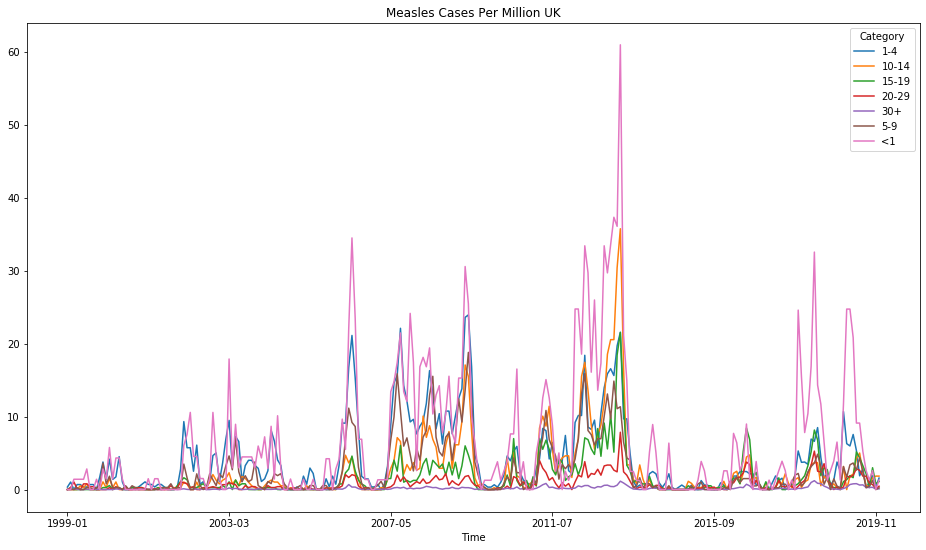

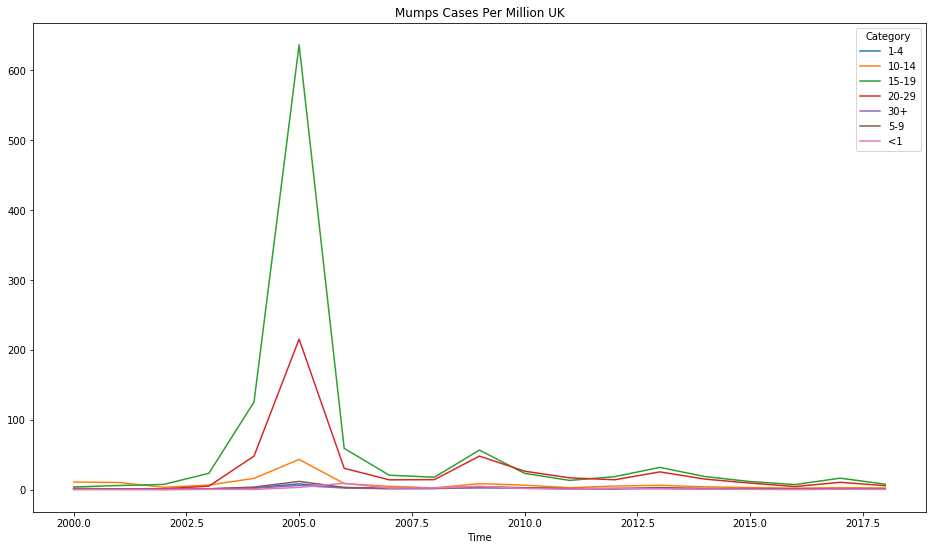

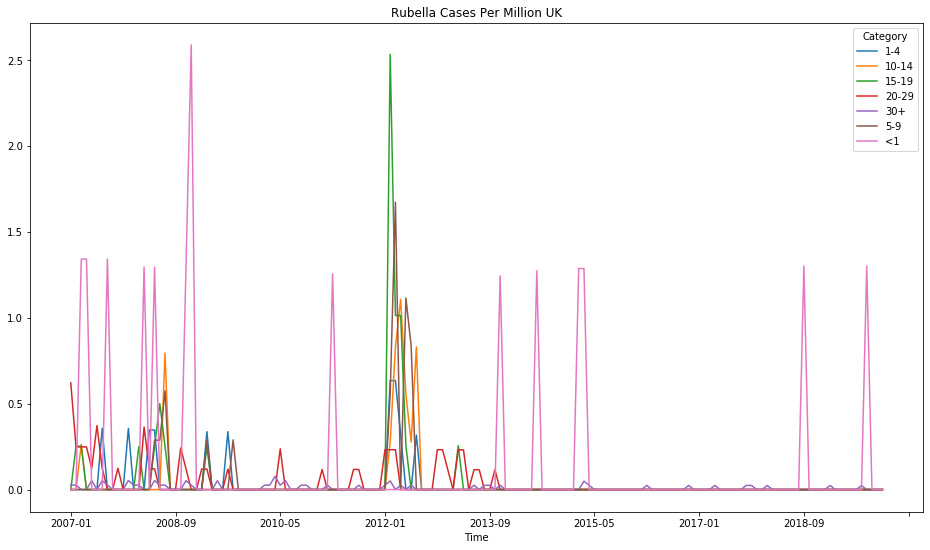

In [4]:
for d in ['Measles', 'Mumps', 'Rubella']:
    ecdc_temp = ecdc_age.loc[lambda s: s['HealthTopic'] == d][['Time', 'Category', 'Value']]
    ecdc_temp = ecdc_temp.pivot(index='Time', columns='Category', values='Value')
    ecdc_temp = ecdc_temp.apply(pd.to_numeric)
    ecdc_temp.to_csv(r'./'+d+'_data_processed.csv', index = True)
    plot = ecdc_temp.plot(figsize=(16,9),title=d+" Cases Per Million UK")
    plt.savefig(d+"Plot")

## Cumulative infected

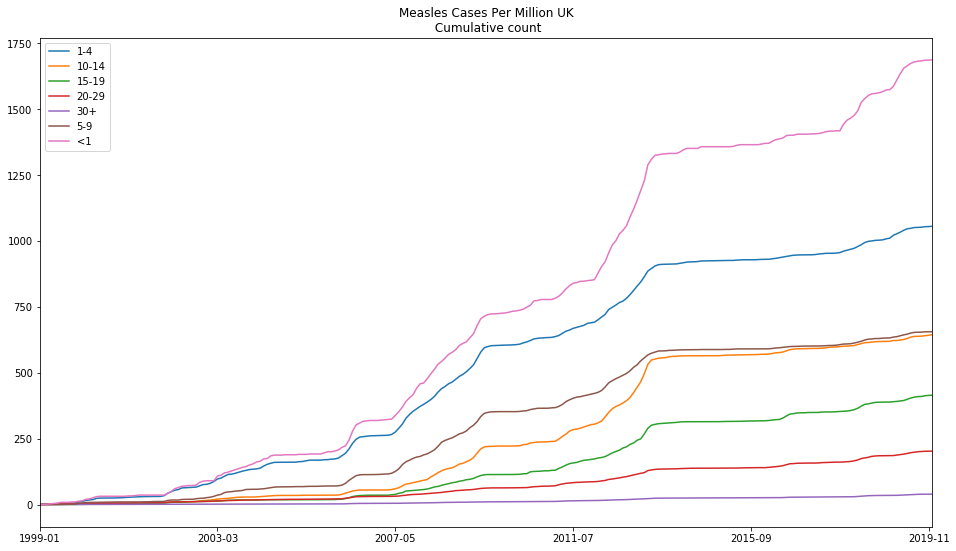

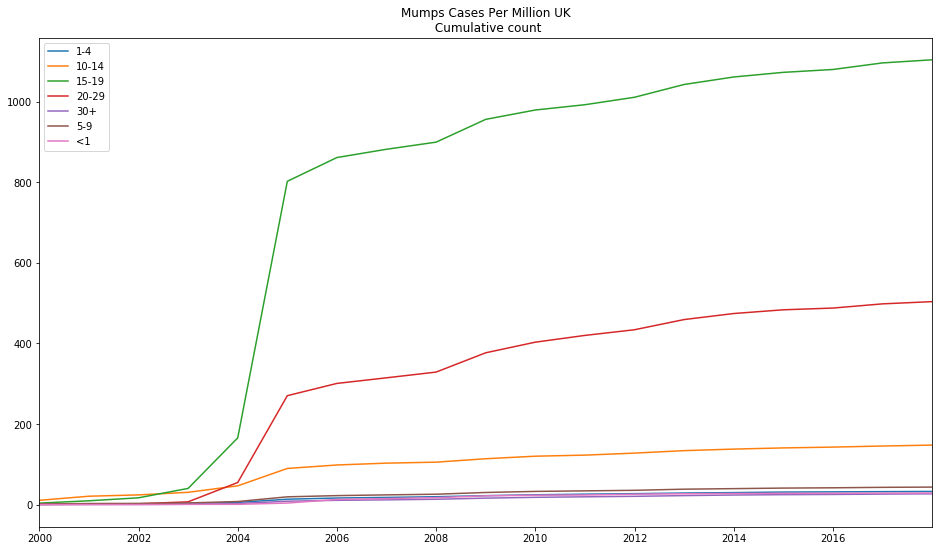

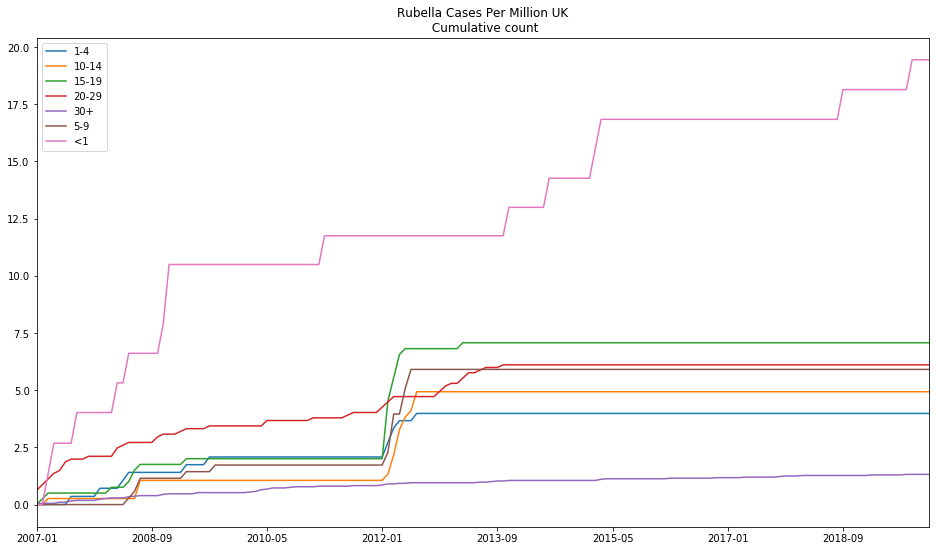

In [62]:
for d in ['Measles', 'Mumps', 'Rubella']:
    ecdc_disease = pd.read_csv(r'./'+d+'_data_processed.csv')
    ecdc_disease_noTime = ecdc_disease.drop("Time", axis=1)
    ecdc_disease_Cumulative = ecdc_disease_noTime.apply(lambda x: np.cumsum(x))
    
    #ecdc_disease_CumulativeTime = ecdc_disease_Cumulative.insert(0, "Time",ecdc_disease["Time"])
    plot = ecdc_disease_Cumulative.plot(figsize=(16,9),title=d+" Cases Per Million UK\n Cumulative count")
    locs, labels = plt.xticks()
    plt.xticks(locs[0:-1], ecdc_disease["Time"][locs])
    plt.savefig(d+"_Total_Infected_Plot")

#### Smoothing data

* lowess
* Cubic Splines

In [3]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from scipy.interpolate import CubicSpline

/home/fbasini/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


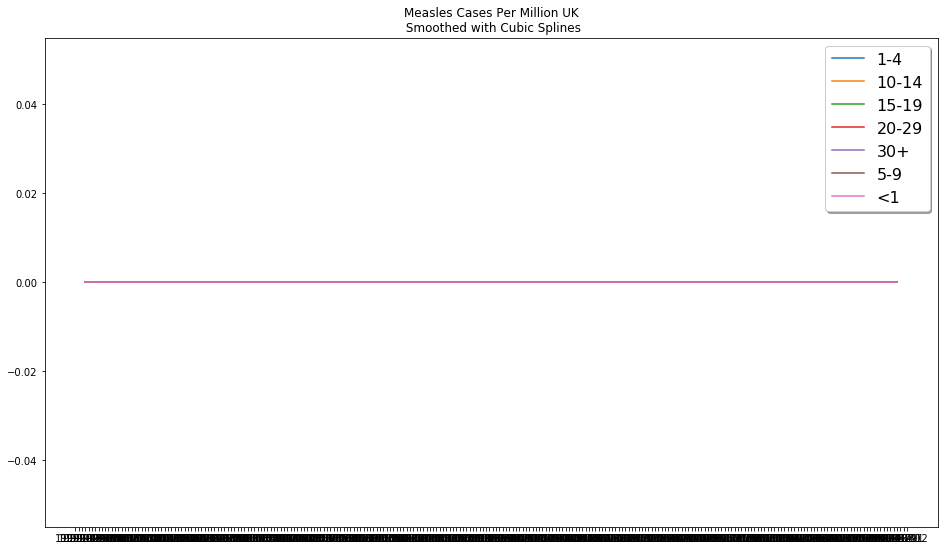

In [11]:
#for d in ['Measles', 'Mumps', 'Rubella']:
for d in ['Measles']:
    ecdc_disease = pd.read_csv(r'./'+d+'_data_processed.csv')
    
    #Time is different
    if d == "Mumps":
        t_0 = int(min(ecdc_disease["Time"]))
        t_last = int(max(ecdc_disease["Time"]))
        Lowess_time = np.linspace(t_0, t_last+1, num = (t_last-t_0+1))
     #   Cont_time = np.arange(t_0, t_last)
    else:
        t_0 = int(min(ecdc_disease["Time"])[0:4])
        t_last = int(max(ecdc_disease["Time"])[0:4])
        Lowess_time = np.linspace(t_0, t_last+1, num = (t_last-t_0+1)*12)
    #    Cont_time = np.arange(t_0, t_last, step = 1/12)
    
    #dropping
    ecdc_disease_temp = ecdc_disease.drop("Time", axis=1)
    fig = plt.figure(figsize=(16,9))
    for aa in ecdc_disease_temp.columns:
        #ecdc_disease_lowess = lowess(ecdc_disease_temp[aa], Lowess_time, frac=1./100)
        #plt.plot(ecdc_disease["Time"], ecdc_disease_lowess, label = aa, lw=1.5)
        #SPLINES
        ecdc_disease_splines = CubicSpline(Lowess_time, ecdc_disease_temp[aa])
        plt.plot(ecdc_disease["Time"], ecdc_disease_splines(Lowess_time), label = aa, lw=1.5)
        
    plt.title(d+" Cases Per Million UK\n Smoothed with Cubic Splines")
    plt.legend(shadow=True, fontsize=16)
    #plt.savefig(d+"Plot")